<a href="https://colab.research.google.com/github/ritwiks9635/CNN_Project_File/blob/main/Facial_Expression_Recognition_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Facial Expression Recognition with PyTorch**

In [ ]:
#!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

In [2]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052
Receiving objects: 100% (34052/34052), 52.31 MiB | 28.82 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (35887/35887), done.


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation/'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [6]:
train_augs = T.Compose(
    [
        T.RandomHorizontalFlip(p = 0.5),
        T.RandomRotation(degrees = (-20, +20)),
        T.ToTensor()
    ])

valid_augs = T.Compose(
    [
        T.ToTensor()
    ])

In [7]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

In [8]:
print("Total no of training sets :: ", len(trainset))
print("Total No of validation sets :: ", len(validset))

Total no of training sets ::  28821
Total No of validation sets ::  7066


In [9]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '0')

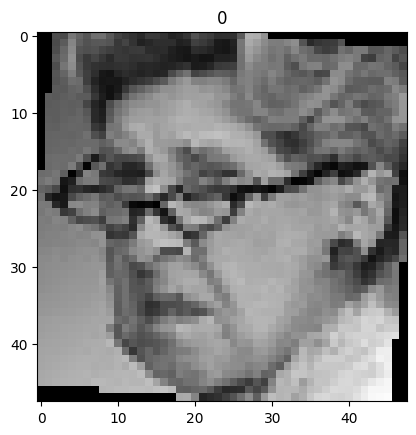

In [10]:
img, label = trainset[9]

plt.imshow(img.permute(1, 2, 0))
plt.title(label)

In [11]:
from torch.utils.data import DataLoader

In [12]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [13]:
print("No of batches in trainloader ::", len(trainloader))
print("No of batches in validloader ::", len(validloader))

No of batches in trainloader :: 901
No of batches in validloader :: 221


In [14]:
for image, label in trainloader:
    print("One image batch shape :::", image.shape)
    print("One label batch shape :::", label.shape)
    break

One image batch shape ::: torch.Size([32, 3, 48, 48])
One label batch shape ::: torch.Size([32])


In [15]:
import timm
from torch import nn

In [16]:
class FaceModel(nn.Module):
  def __init__(self) -> None:
      super(FaceModel, self).__init__()
      self.eff_net = timm.create_model(model_name=MODEL_NAME, pretrained=True, num_classes=7)

  def forward(self, images, labels=None):
    logits = self.eff_net(images)

    if labels != None:
      loss = nn.CrossEntropyLoss()(logits, labels)
      return logits, loss

    return logits

In [17]:
model = FaceModel()
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 

In [18]:
from tqdm import tqdm

In [19]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [20]:
def train_fn(model: FaceModel, dataloader: DataLoader, optimizer, current_epo):
  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[TRAIN]' + str(current_epo+1) + '/' + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': '%6f'%(float(total_loss / (t+1))),
                    'acc': '%6f'%(float(total_acc / (t+1)))
                    })
  return total_loss / len(dataloader), total_acc / len(dataloader)

In [23]:
def eval_fn(model: FaceModel, dataloader: DataLoader, current_epo):
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[VALID]' + str(current_epo+1) + '/' + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)


    logits, loss = model(images, labels)


    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': '%6f'%(float(total_loss / (t+1))),
                    'acc': '%6f'%(float(total_acc / (t+1)))
                    })
  return total_loss / len(dataloader), total_acc / len(dataloader)

In [22]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)

In [24]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_fn(model, validloader, i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    best_valid_loss = valid_loss
    print('SAVED-BEST-WEIGHTS')

EPOCH[VALID]1/15: 100%|██████████| 221/221 [00:06<00:00, 32.36it/s, loss=1.332783, acc=0.492038]


SAVED-BEST-WEIGHTS


EPOCH[VALID]2/15: 100%|██████████| 221/221 [00:06<00:00, 36.33it/s, loss=1.225894, acc=0.521417]


SAVED-BEST-WEIGHTS


EPOCH[VALID]3/15: 100%|██████████| 221/221 [00:06<00:00, 32.59it/s, loss=1.111464, acc=0.584722]


SAVED-BEST-WEIGHTS


EPOCH[VALID]4/15: 100%|██████████| 221/221 [00:06<00:00, 36.40it/s, loss=1.093638, acc=0.573910]


SAVED-BEST-WEIGHTS


EPOCH[VALID]5/15: 100%|██████████| 221/221 [00:06<00:00, 34.53it/s, loss=1.092012, acc=0.593728]


SAVED-BEST-WEIGHTS


EPOCH[VALID]6/15: 100%|██████████| 221/221 [00:06<00:00, 32.83it/s, loss=1.026244, acc=0.610359]


SAVED-BEST-WEIGHTS


EPOCH[VALID]8/15: 100%|██████████| 221/221 [00:06<00:00, 32.49it/s, loss=1.022688, acc=0.617484]


SAVED-BEST-WEIGHTS


EPOCH[VALID]9/15: 100%|██████████| 221/221 [00:06<00:00, 35.41it/s, loss=0.994135, acc=0.633364]


SAVED-BEST-WEIGHTS


EPOCH[VALID]12/15: 100%|██████████| 221/221 [00:06<00:00, 33.08it/s, loss=0.988792, acc=0.640935]


SAVED-BEST-WEIGHTS


EPOCH[VALID]14/15: 100%|██████████| 221/221 [00:06<00:00, 33.85it/s, loss=0.976426, acc=0.647015]


SAVED-BEST-WEIGHTS


EPOCH[VALID]15/15: 100%|██████████| 221/221 [00:06<00:00, 33.68it/s, loss=1.016594, acc=0.646906]


In [25]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

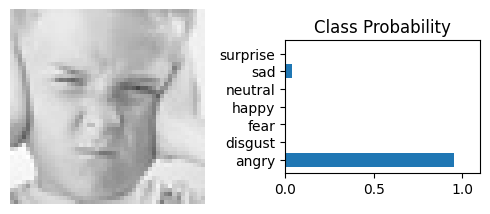

In [28]:
idx = 2

model.load_state_dict(torch.load('/content/best-weights.pt'))
image, label = validset[idx]
image = image.unsqueeze(0)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim=1)(logits)

view_classify(image.squeeze(), probs)